In [2]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. TCGA copy number

1. i can load the gatk seg file into igv for visualization. the file extension needs to be .seg

2. decided to use the TCGA file with germline CNVs removed for the comparison I used the same TCGA curated germline events to filter out germline events from HTMCP cohort as well. 

3. i downloaded the population CNVS here: is this from 1000 genomes
/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/population_cnv.txt

4. tcga core data freeze list: 178 samples with SNP6 array copy number data. extended data include additional 50 samples.

5. snp6 copy number analysis was applied to the 178 core samples. in supplimentary, it states "Somatic copy number alterations in 178 CESC tumors were determined with SNP 6.0 arrays. "

<font color='red'>
6. TCGA excluded peaks with more than 30 genes. also TCGA removed germline CNVs
</font>

7. GISTIC2.0 amplification and deletion plots within copy number clusters. Chromosomal locations for peaks of significantly recurrent focal amplifications (red) and deletions (blue) are plotted by −log10 q value for the high (CN High) and low (CN Low) copy number clusters. Peaks are annotated with cytoband and candidate driver genes. The total number of genes in the peak region is indicated in parentheses. Peaks with more than 30 genes in the peak region are excluded. Any genes annotated have a significant positive correlation with mRNA expression

data can be download here:

http://firebrowse.org/

http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/CESC/20160128/

in firbrowse, there are 295 samples with snp6 copy number results including 586 tumour or normals. not sure why. but it makes sense to have normals in this file because copy number ratio is standardardized to a panel of normals. so normals can be compared to the panel as well.

copy number analysis GISTIC results are here with 295 patients:
http://gdac.broadinstitute.org/runs/analyses__2016_01_28/reports/cancer/CESC-TP/CopyNumber_Gistic2/nozzle.html

TCGA CESC had 178 core samples plus 50 extended cases. but in firebrowse we got 295 samples for the cesc. not sure why. i am confused. so to keep it simple, I will stick to the 178 samples for the purposes of comparison with HTMCP. the 178 core samples include both squamous and adeno cases. so not like we only look at squamous cases. should be fine.

decide which file to use. 
"_scna_minus_germline_cnv_" has much less rows, indicating germline cnvs were removed. maybe one normal against a panel of normal can detect germline cnvs, so the file excluded these events. When we run our HTMCP cohort, we did not remove germline cnvs, so i think i should use the other file which include germline cnvs. 

to determine if a segment is amplfied or deleted based on the segment_mean value, (logT/N ratio). I tend to use cutoffs; amp>=0.58= log2(3/2); del <=-1=log2(1/2), this seems to be too stringent. 

following paper used 0.25 for copy gain and -0.25 for copy loss.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4392457/
There are no standardised log2 ratio cut-offs to define low-amplitude copy number gain/loss and high amplitude amplification/deletion. Based on the available published literature, we used a log2 ratio cut-off of +/− 0.25 to define copy number gain/loss and a log2 ratio cut-off of +/− 0.8 to define amplification and deletion [7,18,19].

https://www.nature.com/articles/nature20805
esophageal copy number comparison with ESCC and EAC

this google post has some useful information as well:
https://groups.google.com/a/broadinstitute.org/forum/#!topic/gdac-users/__zdXDE-Z5U

this talks about the germline CNVs identified in 1000 genomes.
https://www.biostars.org/p/174343/

this describes how GISTIC works:
http://www.pnas.org/content/104/50/20007.full


Copy number analysis
DNA from each tumour or germline sample was hybridized to Affymetrix SNP 6.0 arrays using protocols at the Genome Analysis Platform of the Broad Institute as previously described51. Briefly, Birdseed was used to infer a preliminary copy number at each probe locus from raw .cel files52. For each tumour, genome-wide copy number estimates were refined using tangent normalization, in which tumour signal intensities are divided by signal intensities from the linear combination of all normal samples that are most similar to the tumour16. Individual copy number estimates then underwent segmentation using circular binary segmentation53, and segmented copy number profiles for tumour and matched control DNAs were analysed using Ziggurat Deconstruction54. Significance of copy number alterations were assessed from the segmented data using GISTIC2.0 (version 2.0.22)54. For the purpose of this analysis, an arm-level event was defined as any event spanning more than 50% of a chromosome arm. For copy number-based clustering, tumours were clustered based on copy number at regions using GISTIC analysis. Clustering was done in R on the basis of Euclidean distance using Ward’s method. Allelic and integer copy number, tumour purity and tumour ploidy were calculated using the ABSOLUTE algorithm55.



# ARE THESE THRESHOLDS  REASONABLE?
remember now the final version we only want 3 tracks, the comparison is tcga vs hiv- and hiv+ vs hiv-

# goals

* to display the copy number landscape using gatk cnv results
* to compare significant arm level alterations among three groups: tcga, htmcp hiv+, and htmcp hiv-, all comparisons are made against hiv- group

# constants

In [7]:
amp_threshold = 0.1 # suggested by Andrew Cherniack
del_threshold = -0.1
arm_threshold = 0.25
num_tcga_patients = 177
num_htmcp_patients = 118
num_htmcp_hiv_pos_patients = 73
num_htmcp_hiv_neg_patients = 45

# files

In [8]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'
bindir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/'
chr_accu_length_f = f'{wkdir}chromosome_accumulative_length.txt'
chromosomef = f'{wkdir}chromosome_coordinates.txt'

# this removed germline cnvs
tcga_cn_file = '/home/szong/bin/GISTIC_2_0_22/tcga/segmentationfile.txt'
# tcga_cn_file is extracted from below minus_germline files downloaed from firebrowse
# tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
# tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.seg.txt'
tcga_core_sample_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/TCGA_178_core_samples.txt'
htmcp_hiv_neg_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/segmentationfile.txt'
htmcp_hiv_pos_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/segmentationfile.txt'
# htmcp_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
hivpos_uniqamp_armsf = f'{wkdir}hivpos_uniqamp_arms_{arm_threshold}.txt'
hivneg_uniqamp_armsf = f'{wkdir}hivneg_uniqamp_arms_{arm_threshold}.txt'
hivpos_uniqdel_armsf = f'{wkdir}hivpos_uniqdel_arms_{arm_threshold}.txt'
hivneg_uniqdel_armsf = f'{wkdir}hivneg_uniqdel_arms_{arm_threshold}.txt'
tcga_uniqdel_armsf = f'{wkdir}tcga_uniqdel_arms_{arm_threshold}.txt'
tcga_uniqamp_armsf = f'{wkdir}tcga_uniqamp_arms_{arm_threshold}.txt'
hivneg2_uniqdel_armsf = f'{wkdir}hivneg2_uniqdel_arms_{arm_threshold}.txt'
hivneg2_uniqamp_armsf = f'{wkdir}hivneg2_uniqamp_arms_{arm_threshold}.txt'



In [9]:
tcga = pd.read_csv(tcga_cn_file, sep='\t')
tcga = tcga[tcga.columns[[1, 2,3,4, 5, 0]]]
tcga.drop('Num_Probes', axis=1, inplace=True)
tcga[:3]
tcga.shape

,Chromosome,Start,End,Segment_Mean,Samples
0,1,3218610,247813706,0.1305,TCGA-BI-A0VR-01A
1,2,484222,3604951,-0.0074,TCGA-BI-A0VR-01A
2,2,3608623,3608756,-2.1939,TCGA-BI-A0VR-01A


(21932, 5)

In [10]:
tcga_amps = tcga[tcga.Segment_Mean >= amp_threshold]
tcga_dels = tcga[tcga.Segment_Mean <= del_threshold]

In [11]:
tcga_amps.Segment_Mean.describe()
tcga_dels.Segment_Mean.describe()

count    6230.000000
mean        0.595218
std         0.548625
min         0.100100
25%         0.237625
50%         0.437500
75%         0.712850
max         4.679400
Name: Segment_Mean, dtype: float64

count    9025.000000
mean       -1.065045
std         0.996327
min        -7.427400
25%        -1.458300
50%        -0.727900
75%        -0.387700
max        -0.100000
Name: Segment_Mean, dtype: float64

In [31]:
tcga_amps.to_csv(f'{wkdir}tcga_cnv_amps.txt', sep='\t', header=None, index=False)
tcga_dels.to_csv(f'{wkdir}tcga_cnv_dels.txt', sep='\t', header=None, index=False)

# 2. Process TCGA cns

In [32]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n tcga_cnv_amps.txt > tcga_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b tcga_cnv_amps.txt.sorted -wa -wb > tcga_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n tcga_cnv_dels.txt > tcga_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b tcga_cnv_dels.txt.sorted -wa -wb > tcga_cnv_dels_bins_1kb.txt


In [33]:
wkdir

'/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'

In [12]:
def calculate_occurence(f):
    df = pd.read_csv(f, sep='\t', header=None)#, nrows=200)
    df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
    occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end'])['patient'].nunique()#.sort_values(ascending=False)
    recur_cnvs = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

    recur_cnvs.head(2)
    return recur_cnvs

In [ ]:
f = f'{wkdir}tcga_cnv_amps_bins_1kb.txt'
tcga_recur_amps = calculate_occurence(f)

of = f'{f}.patients'
# tcga_recur_amps.to_csv(of, index=False, sep='\t')
tcga_recur_amps = pd.read_csv(of, sep='\t')

In [36]:
tcga_recur_amps.head()
tcga_recur_amps.shape

,bin_chr,bin_start,bin_end,patient
0,1,3218001,3219000,51
1,1,3219001,3220000,51
2,1,3220001,3221000,51
3,1,3221001,3222000,51
4,1,3222001,3223000,51


(2903195, 4)

In [37]:
f = f'{wkdir}tcga_cnv_dels_bins_1kb.txt'
tcga_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
# tcga_recur_dels.to_csv(of, index=False, sep='\t')
tcga_recur_dels = pd.read_csv(of, sep='\t')
tcga_recur_dels[:2]
tcga_recur_dels.shape

,bin_chr,bin_start,bin_end,patient
0,1,3218001,3219000,23
1,1,3219001,3220000,23


(2903195, 4)

In [219]:
# tcga_recur_amps = pd.read_csv(of, sep='\t')
# tcga_recur_amps.head()

In [31]:
f11 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
df11 = pd.read_csv(f11, sep='\t', header=None)
df11.columns = ['bin_chr', 'bin_start', 'bin_end']
df11.set_index(['bin_chr', 'bin_start', 'bin_end'], inplace=True)
# df11['patient'] = 0
df11.head()

Empty DataFrame
Columns: []
Index: [(1, 1, 1000), (1, 1001, 2000), (1, 2001, 3000), (1, 3001, 4000), (1, 4001, 5000)]

In [25]:
def reindex_df(indf, num_patients):
    df = indf.set_index(['bin_chr', 'bin_start', 'bin_end']).reindex(df11.index)
    df.fillna(0, inplace=True)
    df['fraction_patients'] = df.patient/num_patients
    df.drop('patient', inplace=True, axis=1)
    return df

In [26]:
# df_amps.reset_index()['bin_start'].cumsum() # not just accumulateive sum, depending on chr.

In [27]:
def calculate_fractions(df):
    end = 0
    all_positions = []
    all_fractions = []
    for ch, length in enumerate(chr_length):
        ch+=1
        positions = list(end + np.array(df.iloc[df.index.get_level_values('bin_chr') == ch].index.get_level_values('bin_start').tolist()))
        all_positions = all_positions + positions
        fractions = df.iloc[df.index.get_level_values('bin_chr') == ch]['fraction_patients'].tolist()
        all_fractions = all_fractions + fractions
        end+=length
    return (all_positions, all_fractions)




In [28]:
def get_coordinates_fractions(indf, num_patients):
    df = reindex_df(indf, num_patients)
    coordinates, fractions = calculate_fractions(df)
    return (coordinates, fractions)

In [29]:
def plot_fraction(coordinates, fractions, baseline, cnv_type, ax):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)

In [20]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)

,size
chr,
1,249250621
2,243199373


# 2. Process HTMCP copy number

## all 118 patients

,chr,start,end,Segment_Mean,patient
0,1,10001,63000,-2.710885,HTMCP-03-06-02256
1,1,10001,90000,-0.600141,HTMCP-03-06-02332


count    46227.000000
mean         0.470232
std          0.413566
min          0.100002
25%          0.218220
50%          0.364845
75%          0.570257
max          6.622359
Name: Segment_Mean, dtype: float64

count    61506.000000
mean        -0.570545
std          1.402886
min        -30.034152
25%         -0.645850
50%         -0.413428
75%         -0.241656
max         -0.100008
Name: Segment_Mean, dtype: float64

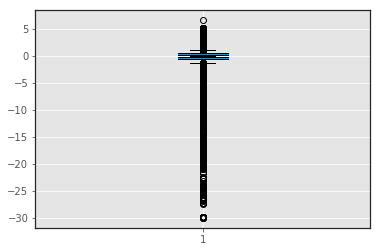

In [407]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_file, sep='\t')
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]

df3.head(2)

htmcp_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_amps.to_csv(f'{wkdir}htmcp_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_dels.to_csv(f'{wkdir}htmcp_cnv_dels.txt', sep='\t', header=None, index=False)

htmcp_amps.Segment_Mean.describe()
_ = plt.boxplot(htmcp_amps.Segment_Mean)

htmcp_dels.Segment_Mean.describe()
_ = plt.boxplot(htmcp_dels.Segment_Mean)

In [399]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_cnv_amps.txt > htmcp_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_cnv_amps.txt.sorted -wa -wb > htmcp_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_cnv_dels.txt > htmcp_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_cnv_dels.txt.sorted -wa -wb > htmcp_cnv_dels_bins_1kb.txt


In [400]:
f = f'{wkdir}htmcp_cnv_amps_bins_1kb.txt'
htmcp_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
# htmcp_recur_amps.to_csv(of, index=False, sep='\t')

In [401]:
f = f'{wkdir}htmcp_cnv_dels_bins_1kb.txt'
htmcp_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
# htmcp_recur_dels.to_csv(of, index=False, sep='\t')

## HIV + patient 73

In [54]:
df3.dtypes

chr             object
start           object
end             object
Segment_Mean    object
patient         object
dtype: object

,chr,start,end,Segment_Mean,patient
0,1,10001,90000,-1.619727,HTMCP-03-06-02414
1,1,10001,90000,-1.871280,HTMCP-03-06-02435


73

count    26735.000000
mean         0.460409
std          0.443659
min          0.100007
25%          0.196269
50%          0.349233
75%          0.555244
max          6.622359
Name: Segment_Mean, dtype: float64

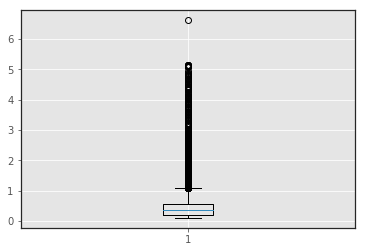

count    39779.000000
mean        -0.565476
std          1.358363
min        -30.034152
25%         -0.639165
50%         -0.421445
75%         -0.257884
max         -0.100009
Name: Segment_Mean, dtype: float64

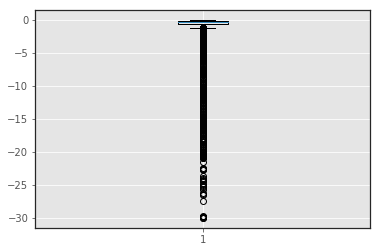

In [57]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_hiv_pos_file, sep='\t')
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]
df3.head(2)
df3.patient.nunique()

htmcp_hiv_pos_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_hiv_pos_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_hiv_pos_amps.to_csv(f'{wkdir}htmcp_hiv_pos_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_hiv_pos_dels.to_csv(f'{wkdir}htmcp_hiv_pos_cnv_dels.txt', sep='\t', header=None, index=False)

htmcp_hiv_pos_amps.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_pos_amps.Segment_Mean)
plt.show()

htmcp_hiv_pos_dels.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_pos_dels.Segment_Mean)

In [58]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_hiv_pos_cnv_amps.txt > htmcp_hiv_pos_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_pos_cnv_amps.txt.sorted -wa -wb > htmcp_hiv_pos_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_hiv_pos_cnv_dels.txt > htmcp_hiv_pos_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_pos_cnv_dels.txt.sorted -wa -wb > htmcp_hiv_pos_cnv_dels_bins_1kb.txt


In [59]:
f = f'{wkdir}htmcp_hiv_pos_cnv_amps_bins_1kb.txt'
htmcp_hiv_pos_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_pos_recur_amps.to_csv(of, index=False, sep='\t')
# htmcp_hiv_pos_recur_amps = pd.read_csv(of, sep='\t')

f = f'{wkdir}htmcp_hiv_pos_cnv_dels_bins_1kb.txt'
htmcp_hiv_pos_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_pos_recur_dels.to_csv(of, index=False, sep='\t')
# htmcp_hiv_pos_recur_dels = pd.read_csv(of, sep='\t')

# HIV - patients: 45

,chr,start,end,Segment_Mean,patient
0,1,10001,63000,-2.710885,HTMCP-03-06-02256
1,1,10001,90000,-0.600141,HTMCP-03-06-02332


45

count    19492.000000
mean         0.483705
std          0.367899
min          0.100002
25%          0.262076
50%          0.382057
75%          0.596351
max          5.250338
Name: Segment_Mean, dtype: float64

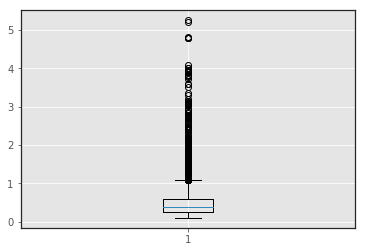

count    21727.000000
mean        -0.579825
std          1.480923
min        -29.981299
25%         -0.662060
50%         -0.395072
75%         -0.214237
max         -0.100008
Name: Segment_Mean, dtype: float64

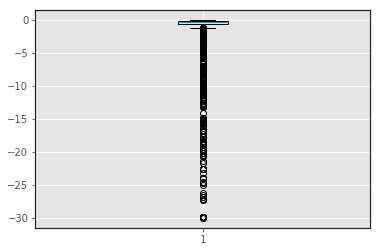

In [60]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_hiv_neg_file, sep='\t')
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]
df3.head(2)
df3.patient.nunique()

htmcp_hiv_neg_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_hiv_neg_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_hiv_neg_amps.to_csv(f'{wkdir}htmcp_hiv_neg_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_hiv_neg_dels.to_csv(f'{wkdir}htmcp_hiv_neg_cnv_dels.txt', sep='\t', header=None, index=False)

htmcp_hiv_neg_amps.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_neg_amps.Segment_Mean)
plt.show()

htmcp_hiv_neg_dels.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_neg_dels.Segment_Mean)

In [61]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_hiv_neg_cnv_amps.txt > htmcp_hiv_neg_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_neg_cnv_amps.txt.sorted -wa -wb > htmcp_hiv_neg_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_hiv_neg_cnv_dels.txt > htmcp_hiv_neg_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_neg_cnv_dels.txt.sorted -wa -wb > htmcp_hiv_neg_cnv_dels_bins_1kb.txt


In [62]:
f = f'{wkdir}htmcp_hiv_neg_cnv_amps_bins_1kb.txt'
htmcp_hiv_neg_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_neg_recur_amps.to_csv(of, index=False, sep='\t')

f = f'{wkdir}htmcp_hiv_neg_cnv_dels_bins_1kb.txt'
htmcp_hiv_neg_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_neg_recur_dels.to_csv(of, index=False, sep='\t')

# 3. plot cnvs

In [10]:
def plot_cnv(ax, baseline, amps, dels, num_patients, vlns):
    ticks = [0, 0.4, 0.8, 1.2, 1.6]
    ticklabels = [0.8, 0.4, 0, 0.4, 0.8]
    ax.set_yticks(ticks, minor=False)
    ax.set_yticklabels(ticklabels, minor=False)
    # ax.set_frame_on(False) # this turn off frame
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    _ = ax.hlines(baseline, 0, vlns[-2], color='black', linewidth=.7)
    for vl in vlns:
        _ = ax.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
    
#     _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
#     _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
    coordinates, fractions = get_coordinates_fractions(amps, num_patients)
    plot_fraction(coordinates, fractions, baseline, 'amps', ax)
    coordinates, fractions = get_coordinates_fractions(dels, num_patients)
    plot_fraction(coordinates, fractions, baseline, 'dels', ax)

In [21]:
# plot baseline
start = 0
end = 0
# baseline = 1
vlns = []
mpnts = []
for ch, length in enumerate(chr_length[:-1]):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    mpnts.append(midpoint)
#     _ = ax0.text(midpoint, 1, ch, ha='center')
    if ch %2 == 1:
        vlns.append(start)
        vlns.append(end)
#         _ = fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
#         _= ax0.vlines(start, 0, 10, color='gray', linestyle='--', linewidth=.5)
#         _= ax0.vlines(end, 0, 10, color='gray', linestyle='--', linewidth=.5)
    start+=length
#     _ = ax0.text(midpoint, 1, ch, ha='center')


In [11]:
def plot_cytobands(df, ax, clr, y_coord):
    """
    keep in mind sometime notebook does render properly, some lines seem missing, 
    but it will show up when you open the png file. 
    """
    for ix, row in df.iterrows():
        chrom = row.chr
        start = row.start
        end = row.end
        cytoband = row.cytoband
        print(start, end, (end-start), cytoband)
        ax.hlines(y_coord, start, end, color=clr, linewidth=14) 

# plot cytoband

In [44]:
tcga_bandf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/supplemental_Table_7-Amp_Del_Peaks.xlsx'
tcga_band_amps = pd.read_excel(tcga_bandf, sheet_name='All_amps')
tcga_band_amps[:2]
tcga_amps_bands = tcga_band_amps.columns.tolist()
tcga_amps_bands.remove('cytoband')
len(tcga_amps_bands)

,cytoband,11q22.1,3q26.31,20q11.21,8q24.21,3q28,11q13.3,17q25.1,19q13.13,9p24.1,...,6q12,14q11.2,13q34,1p31.3,8p11.21,22q13.31,Xp22.11,11q13.2,2q32.3,19q13.32
0,q value,8.2231e-24,2.0738e-15,6.7744e-10,1.4874e-08,1.3329e-14,1.799e-07,9.4255e-05,2.6629e-05,0.00020757,...,0.10033,0.12486,0.10443,0.17237,0.22602,0.2308,0.23765,0.0005581,0.24581,1.1211e-05
1,residual q value,9.9276e-20,2.4074e-10,6.7744e-10,1.4874e-08,1.3817e-05,4.7655e-05,9.4255e-05,9.475e-05,0.00020757,...,0.10033,0.12486,0.14977,0.17237,0.22602,0.2308,0.23765,0.24448,0.24581,0.41875


29

In [229]:
tcga_bandf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/supplemental_Table_7-Amp_Del_Peaks.xlsx'
tcga_band_dels = pd.read_excel(tcga_bandf, sheet_name='All_dels')
tcga_band_dels[:2]
tcga_dels_bands = tcga_band_dels.columns.tolist()
tcga_dels_bands.remove('cytoband')
len(tcga_dels_bands)

,cytoband,2q37.1,2q22.1,11q25,4q35.2,19p13.3,10q23.31,13q14.2,1p36.23,17q25.3,...,8p23.3,16q23.1,11p15.1,19p13.12,1p13.2,16p13.3,3p22.1,21q21.1,5q35.3,16q24.3
0,q value,2.1181e-25,6.4977e-17,2.8223e-14,6.1861e-12,5.1501e-12,7.5863e-10,3.9893e-10,4.5785e-05,0.00040073,...,0.16465,0.046327,0.20387,0.01539,0.17674,0.21081,0.23848,0.23482,0.24783,0.0506
1,residual q value,1.2059e-22,7.9934e-15,2.7755e-14,1.2885e-11,2.4884e-11,7.5863e-10,3.3152e-07,5.5176e-05,0.00040073,...,0.15897,0.17674,0.21041,0.21041,0.21194,0.21194,0.23848,0.23848,0.25985,0.27771


38

In [39]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df_cytoband = pd.read_csv(f3, header=None, sep='\t')
df_cytoband.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df_cytoband['cytoband'] = df_cytoband.chr + df_cytoband['cytoband']
df_cytoband['chr'] = df_cytoband['chr'].replace({'X':'23', 'Y':'24'}).astype(str)

df_cytoband.head(2)
df_cytoband.tail()
df_cytoband.shape
df_cytoband.dtypes

,chr,start,end,cytoband,comments
0,1,0,2300000,1p36.33,gneg
1,1,2300000,5400000,1p36.32,gpos25


,chr,start,end,cytoband,comments
857,24,15100000,19800000,Yq11.221,gpos50
858,24,19800000,22100000,Yq11.222,gneg
859,24,22100000,26200000,Yq11.223,gpos50
860,24,26200000,28800000,Yq11.23,gneg
861,24,28800000,59373566,Yq12,gvar


(862, 5)

chr         object
start        int64
end          int64
cytoband    object
comments    object
dtype: object

In [40]:
chromosomes = pd.read_csv(chr_accu_length_f, sep='\t')
chromosomes[:4]
chromosomes.dtypes

,chrom,length,cumulative_length
0,0,0,0
1,1,249250621,249250621
2,2,243199373,492449994
3,3,198022430,690472424


chrom                int64
length               int64
cumulative_length    int64
dtype: object

In [41]:
chromosomes['end'] = chromosomes.cumulative_length.shift(-1)
chroms = chromosomes.loc[0:23,['cumulative_length','end']]
chroms['chrom'] = [i for i in range(1, 25)]
# chroms.to_csv(chromosomef, index=False)

In [463]:
# # detour to get arm coordiate to be deleted
# out = []
# # df_cytoband['chr'] = df_cytoband['chr'].replace({'X':'23', 'Y':'24'}).astype(int)
# for chrom in df_cytoband.chr.unique():
#     for arm in ['p', 'q']:
# #         print(chrom, arm)
#         offset = 0
# #         df_cytoband[(df_cytoband.chr==1)]#&(df_cytoband.cytoband.str.contains('p'))]
#         p = df_cytoband[(df_cytoband.chr==str(chrom))&(df_cytoband.cytoband.str.contains(arm))][['start', 'end']].values.ravel()
#         start = p.min()+offset+1
#         end = p.max()+offset
#         out.append([chrom, arm, start, end])
# out = pd.DataFrame(out)

In [24]:
def arm_coordinates(df_cytoband, chromosomes): # get arm coordinates to delete
    out = []
    for chrom in df_cytoband.chr.astype(int64).unique():

        print("xxx", chrom, chromosomes.query('chrom == "{}"'.format(chrom-1)))
        offset =  chromosomes.query('chrom == "{}"'.format(chrom-1))['cumulative_length'].values[0]
        offset =0
#         print('zzz', offset)
        for arm in ['p', 'q']:
            print('here', chrom, arm)
            p = df_cytoband[(df_cytoband.chr==chrom)&(df_cytoband.cytoband.str.contains(arm))][['start', 'end']].values.ravel()
            print('yyy', p)
            start = p.min()+offset+1
            end = p.max()+offset
            out.append([chrom, arm, start, end])
    return pd.DataFrame(out)

In [42]:
out = arm_coordinates(df_cytoband, chromosomes)

xxx 1    chrom  length  cumulative_length          end
0      0       0                  0  249250621.0
here 1 p
yyy []


ValueError: zero-size array to reduction operation minimum which has no identity

In [464]:
out[4]  = out[[0,1]].apply(lambda x: ''.join(x.astype(str)), axis=1)

In [465]:
out.to_csv(f'{wkdir}chromosome_arm_coordinates_new.txt', sep='\t', index=False, header=False)

In [466]:
48/188


0.2553191489361702

In [23]:
def get_cytoband_coords(df_cytoband):
    # both chromosome size file and cytoband file has consistent chromosome size, checked
    chr_offset = 0 # chromosome offset
    cbands = []
    chromsomes = []
    for chr in np.arange(1,25):
        dfchr = df_cytoband[df_cytoband['chr']=='{}'.format(chr)]
        for idx, row in dfchr.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + chr_offset
            width = int(end - start)
    #         print(chr, start, end, cytoband)
            cbands.append([chr, start, end, cytoband])
        chr_offset+=max(dfchr.end)
#         print(chr, max(dfchr.end), chr_offset)
        chromsomes.append([chr, max(dfchr.end), chr_offset])


        cytobands = pd.DataFrame(cbands)
        cytobands.columns = ['chr', 'start', 'end', 'cytoband']
        cytobands[:4]
#     pd.DataFrame(chromsomes).to_csv(chr_accu_length_f, index=False, header=False, sep='\t')
    return cytobands

In [45]:
cytobands = get_cytoband_coords(df_cytoband)
tcga_amp_bands_toplot = cytobands[cytobands.cytoband.isin(tcga_amps_bands)]
tcga_del_bands_toplot = cytobands[cytobands.cytoband.isin(tcga_dels_bands)]

NameError: name 'tcga_dels_bands' is not defined

In [255]:
tcga_amp_bands_toplot.shape
tcga_del_bands_toplot.shape

(29, 4)

(38, 4)

## HIV + cytobands

In [34]:
hivpos_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/amp_genes.conf_99.txt'
hivpos_delf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/del_genes.conf_99.txt'
hivneg_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/amp_genes.conf_99.txt'
hivneg_delf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/del_genes.conf_99.txt'

In [35]:
hivpos_band_amps = pd.read_csv(hivpos_ampf, sep='\t')
hivpos_band_amps[:2]
hivpos_amps_bands = hivpos_band_amps.columns.tolist()
hivpos_amps_bands.remove('cytoband')
len(hivpos_amps_bands)

hivpos_band_dels = pd.read_csv(hivpos_delf, sep='\t')
hivpos_band_dels[:2]
hivpos_dels_bands = hivpos_band_dels.columns.tolist()
hivpos_dels_bands.remove('cytoband')
len(set(hivpos_dels_bands))



,cytoband,11q22.1,8q24.21,18p11.31,2q31.1,11p13,1p32.1,3q28,2p11.2,13q22.1,20q11.21,17q12,21q22.2,Unnamed: 13
0,q value,3.5447e-09,0.00010454,0.0001414,0.0039549,0.0059099,0.015552,0.015552,0.020664,0.063844,0.075751,0.12249,0.17583,NaN
1,residual q value,3.5447e-09,0.00010454,0.0001414,0.0039549,0.0059099,0.015552,0.015552,0.020664,0.063844,0.075751,0.12249,0.17583,NaN


13

,cytoband,2q22.1,2q36.3,4q35.2,19p13.3,11q24.3,19p13.3.1,4q21.3,5q14.2,21p11.2,...,17q25.3,21p11.2.1,17q12,13q21.32,3p14.2,6p21.31,6q25.3,13q12.11,10q23.2,Unnamed: 23
0,q value,1.0432e-15,1.5195e-09,2.7924e-05,1.0507e-08,0.00084018,6.012e-07,0.0034853,0.017877,0.0060611,...,0.007495,0.0031252,0.0068822,0.031135,0.011441,0.1141,0.14125,0.0064176,0.22676,NaN
1,residual q value,3.1363e-13,5.6651e-06,0.00015611,0.00052441,0.00089139,0.0014456,0.018022,0.018022,0.022924,...,0.043079,0.043079,0.048472,0.10264,0.10989,0.10989,0.13929,0.17275,0.22676,NaN


23

In [36]:
hivneg_band_amps = pd.read_csv(hivneg_ampf, sep='\t')
hivneg_band_amps[:2]
hivneg_amps_bands = hivneg_band_amps.columns.tolist()
hivneg_amps_bands.remove('cytoband')
len(hivneg_amps_bands)

hivneg_band_dels = pd.read_csv(hivneg_delf, sep='\t')
hivneg_band_dels[:2]
hivneg_dels_bands = hivneg_band_dels.columns.tolist()
hivneg_dels_bands.remove('cytoband')
len(hivneg_dels_bands)



,cytoband,3q28,11q22.1,1q21.3,8q24.22,15q26.1,2p24.3,19q13.43,Unnamed: 8
0,q value,0.0018661,0.0019279,0.008915,0.041088,0.051705,0.11758,0.13682,NaN
1,residual q value,0.0018661,0.0019279,0.008915,0.041088,0.051705,0.11758,0.13682,NaN


8

,cytoband,21p11.2,4p15.1,11q25,13q13.2,19p13.3,2q37.1,21p11.2.1,4q24,21q11.2,...,1p13.2,22q13.31,2q22.1,19p12,17q25.3,1p36.22,3p14.1,10p11.1,7q11.23,Unnamed: 22
0,q value,7.1841e-09,0.00050867,0.00050867,0.00050867,0.00050867,0.00050867,0.00050867,0.019728,0.04857,...,0.036117,0.13227,0.04368,0.10815,0.14117,0.14117,0.1701,0.1701,0.19919,NaN
1,residual q value,3.4632e-08,0.00050867,0.00050867,0.00050867,0.00050867,0.00055351,0.034304,0.036117,0.049987,...,0.11054,0.13005,0.14117,0.14117,0.14587,0.18329,0.18329,0.18329,0.19022,NaN


22

In [37]:
hivpos_amp_bands_toplot = cytobands[cytobands.cytoband.isin(hivpos_amps_bands)]
hivpos_del_bands_toplot = cytobands[cytobands.cytoband.isin(hivpos_dels_bands)]
hivpos_amp_bands_toplot.shape
hivpos_del_bands_toplot.shape

NameError: name 'cytobands' is not defined

In [260]:
hivneg_amp_bands_toplot = cytobands[cytobands.cytoband.isin(hivneg_amps_bands)]
hivneg_del_bands_toplot = cytobands[cytobands.cytoband.isin(hivneg_dels_bands)]
hivneg_amp_bands_toplot.shape
hivneg_del_bands_toplot.shape

(7, 4)

(20, 4)

# final plot

## get all files

In [12]:
# tcga
f = f'{wkdir}tcga_cnv_amps_bins_1kb.txt.patients'
tcga_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}tcga_cnv_dels_bins_1kb.txt.patients'
tcga_recur_dels = pd.read_csv(f, sep='\t')

# hiv pos 
f = f'{wkdir}htmcp_hiv_pos_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_pos_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_dels = pd.read_csv(f, sep='\t')

# hiv neg
f = f'{wkdir}htmcp_hiv_neg_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_neg_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_dels = pd.read_csv(f, sep='\t')



In [14]:
# chromosome arm coordinates
f = f'{wkdir}chromosome_arm_coordinates.txt'
arm_coords = pd.read_csv(f, sep='\t')
arm_coords[:2]

# unique arm level alterations



hivpos_uniqamp_arms = pd.read_csv(hivpos_uniqamp_armsf, header=None)[0].tolist()
hivpos_uniqamp_arms

hivneg_uniqamp_arms = pd.read_csv(hivneg_uniqamp_armsf, header=None)[0].tolist()
hivneg_uniqamp_arms

hivpos_uniqdel_arms = pd.read_csv(hivpos_uniqdel_armsf, header=None)[0].tolist()
hivpos_uniqdel_arms

tcga_uniqdel_arms = pd.read_csv(tcga_uniqdel_armsf, header=None)[0].tolist()
tcga_uniqdel_arms

# no tcga uniqamp events
# tcga_uniqamp_arms = pd.read_csv(tcga_uniqamp_armsf, header=None)[0].tolist()
# tcga_uniqamp_arms

# htmcp_uniqamp_arms = pd.read_csv(htmcp_uniqamp_armsf, header=None)[0].tolist()
# htmcp_uniqamp_arms
# htmcp_uniqdel_arms =pd.read_csv(htmcp_uniqdel_armsf,  header=None)[0].tolist()

# htmcp_uniqdel_arms

,chrom,arm,start,end,chr_arm
0,1,p,1,125000000,1p
1,1,q,125000001,249250621,1q


['14q', '6p', '9q', '9p', '16p', '16q']

['8p', '3p', '15q']

['13q', '4q', '21q', '5q']

['6q', '3q', '10q', '22q', '8p', '9p', '13q', '4q', '18q', '5q', '17p']

In [15]:
def plot_arms(arms, arm_coords, ax, alteration_type, edgeclr): # w/o border
    for arm in arms:
        df = arm_coords[arm_coords['chr_arm']==arm]
#         print(df)
        start = df.loc[df.index[0], 'start']
        end = df.loc[df.index[0], 'end']
        if alteration_type.lower() == 'amp':
            faceclr = 'red'
            y1 = 0.8
        elif alteration_type.lower() == 'del':
            faceclr = 'blue'
            y1 = 0
        else: print("Error! invalid copy number type.")
        
#         print(arm, start, end)
#         ax.hlines(y_coord, start, end, color=clr, linewidth=115, alpha=0.2)
        ax.add_patch(matplotlib.patches.Rectangle((start,y1), end-start, 0.8,  
                                                  edgecolor=edgeclr, facecolor=faceclr, 
                                                  alpha=0.2, linewidth=2))
#         if border:
#             print('draw border', start, 0, end-start, 1.6)
#             plt.Rectangle((start, 0), end-start, 1.6, color='black', ax=ax)
# plot_arms(hivpos_uniqamp_arms, arm_coords)#, ax, clr, y_coord)

In [140]:
# tcga_recur_amps.patient.max()
# 144/177

# Take home message

1. hiv + group has more uniq arm level alterations, including both amps and dels. HIV- has 2 unique arms amplified, 3p and 15q, but no unique arm level deletions.

2. hiv- group and tcga are more similar in terms of broad copy number alterations, you can see this by examing the significant arm alterations unique to HIV+ group. 

3. tcga reports more arm deletions while htmcp reports more arm amplifications. tcga reports 9 unique arm deletions, htmcp reports 2 unique arm deletions 21pq. htmcp reports 5 unique arm amplifications.
4. keep in mind this plot does not show the amplitude of the alterations in each and all patients. it only shows the frequency. This is a limitation. it is entirely possible a region is altered at lower frequency, but very high magnitude of gain and loss. So it turns out to be more significant than the higher frequency in another cohort. GISTIC looks for both occurrence and amplitude. 
5. look at the segment_mean distribution: tcga amp mean =0.75, del=-1.2; hiv+ amp=0.62, del=-0.9; hiv- amp=0.58, del=-1.0




what the plot is showing:
1. shows somatic copy number alteration landscape in htmcp hiv+ and - group and tcga cesc cohort
2. shows the fraction of patients have copy gain or loss in each 1kb bin along the entore genome
3. copy gain is defined as gatk copy ratio of tumour to a panel of normals >0.1, and copy loss is defined as segments with copy ratio less than -0.1.
4. unique arm alterations are highlighted in both hiv+ and - group
5. unique arm alterations for tcga and htmcp are highlighted in the last panel. highlights with a black border are unique to tcga 

In [16]:
def plot_chromosomes(df, ax):
    # plot chromosome names


    # plot chromosomes rectangles
    chr_clrs = ['white' if i%2==0 else 'black' for i in df['chrom'] ]
    text_clrs = chr_clrs + ['white']
#     print(chr_clrs)
#     print(text_clrs)
    for ix, row in df.iterrows():
        chrom = int(row.chrom)
        start = row.start
        end = row.end

        _ = ax.add_patch(matplotlib.patches.Rectangle((start,0), end-start, 1.6,  
                                              edgecolor='gray', facecolor=chr_clrs[chrom-1], 
                                              alpha=1, linewidth=2))
        if chrom <= 23:
            _ = ax.text(int((start + end)/2), 0.6, chrom, ha='center', color=text_clrs[chrom])
        else:
            _ = ax.text(int((start + end)/2), 0.6, 'X', ha='center', color=text_clrs[chrom])
            

In [17]:
chrdf = pd.read_csv(chromosomef)
chrdf.columns = ['start', 'end', 'chrom']
chrdf[:2]

,start,end,chrom
0,0,249250621.0,1
1,249250621,492449994.0,2


(0.0, 1.0, 0.0, 1.0)

(0, 3188119038.3) (0, 1.6)


(0, 3188119038.3)

(0.0, 3188119038.3, 0.0, 1.0)

NameError: name 'hivpos_amp_bands_toplot' is not defined

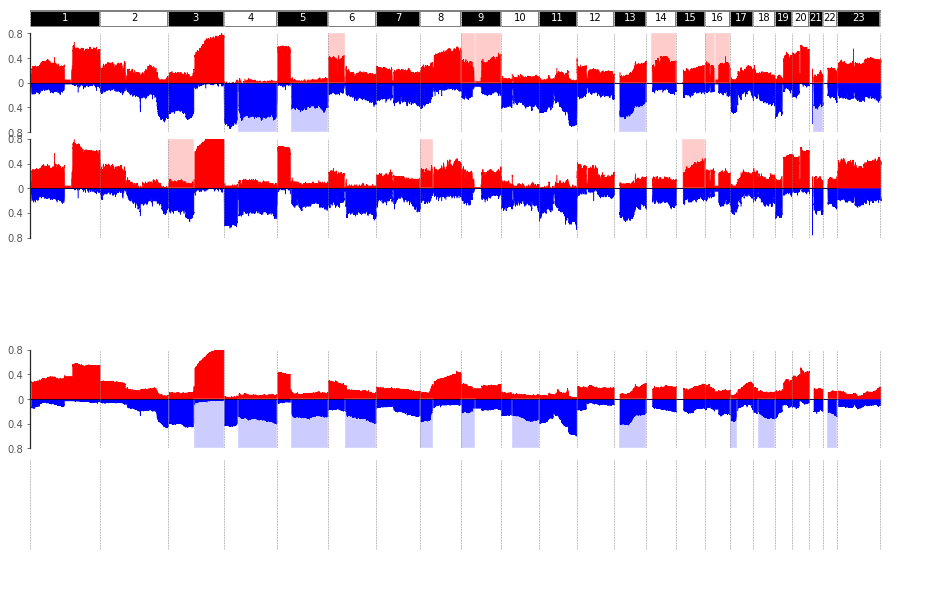

In [33]:
baseline = 0.8
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 6, 6, 6, 6, 6], 
                       hspace=0.08)  # vertical space

# plot chromosomes
ax0 = plt.subplot(gs[0], facecolor='white')
ax0.axis('off')
chrdf = chrdf.iloc[:23,:]

# figuring out xlim and ylim
for vl in vlns:
    _ = ax0.vlines(vl, 0, 1.6, color='white', linestyle='--', linewidth=.5)
xlims = (0, ax0.get_xlim()[1])
ylims = (0, ax0.get_ylim()[1])
_= ax0.set_xlim(xlims)
_ = ax0.set_ylim(ylims)
ylims = (0,1.6)
print(xlims, ylims)
plot_chromosomes(chrdf, ax0)

# plot htmcp cnvs hiv+ 73 patients
ax1 = plt.subplot(gs[1], facecolor='white')
plot_cnv(ax1, baseline, htmcp_hiv_pos_recur_amps, htmcp_hiv_pos_recur_dels, num_htmcp_hiv_pos_patients, vlns)
plot_arms(hivpos_uniqamp_arms, arm_coords, ax1, 'amp', 'white')
plot_arms(hivpos_uniqdel_arms, arm_coords, ax1, 'del', 'white')
_ = ax1.set_xlim(xlims)
_ = ax1.set_ylim(ylims)

# plot htmcp cnvs hiv- 45 patients
ax2 = plt.subplot(gs[2], facecolor='white')
plot_cnv(ax2, baseline, htmcp_hiv_neg_recur_amps, htmcp_hiv_neg_recur_dels, num_htmcp_hiv_neg_patients, vlns)
plot_arms(hivneg_uniqamp_arms, arm_coords, ax2, 'amp', 'white')
_ = ax2.set_xlim(xlims)
_ = ax2.set_ylim(ylims)
# no hivneg uniq deletions

# # plot htmcp cnvs 118 patients
# ax3 = plt.subplot(gs[3], facecolor='white')
# plot_cnv(ax3, baseline, htmcp_recur_amps, htmcp_recur_dels, num_htmcp_patients, vlns)
# plot_arms(htmcp_uniqamp_arms, arm_coords, ax3, 'amp',  'white')
# plot_arms(htmcp_uniqdel_arms, arm_coords, ax3, 'del', 'white')
# _ = ax3.set_xlim(xlims)
# _ = ax3.set_ylim(ylims)

# plot tcga cnvs
ax4 = plt.subplot(gs[4], facecolor='white')
plot_cnv(ax4, baseline, tcga_recur_amps, tcga_recur_dels, num_tcga_patients, vlns)
plot_arms(tcga_uniqdel_arms, arm_coords, ax4, 'del', 'white')

_ = ax4.set_xlim(xlims)
_ = ax4.set_ylim(ylims)

# plot cn significantly altered cytobands
ax5 = plt.subplot(gs[5], facecolor='white')
ax5.set_xlim(xlims)
# plot_arms(hivpos_uniqamp_arms, arm_coords, ax5, 'gray', 0.8)
ax5.axis('off')
for vl in vlns:
    _ = ax5.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
plot_cytobands(hivpos_amp_bands_toplot, ax5, 'red', 1.3)
plot_cytobands(hivneg_amp_bands_toplot, ax5, 'red', 1.1)
plot_cytobands(tcga_amp_bands_toplot, ax5, 'red', 0.9)


plot_cytobands(hivpos_del_bands_toplot, ax5, 'blue', 0.7)
plot_cytobands(hivneg_del_bands_toplot, ax5, 'blue', 0.5)
plot_cytobands(tcga_del_bands_toplot, ax5, 'blue', 0.3)



# plt.savefig(f'{wkdir}cnvs_publication_{arm_threshold}_with_cytoband.png', dpi=300, bbox_inches='tight')